In [1]:
# Ссылка на соревнование https://www.kaggle.com/kartik2112/fraud-detection

In [2]:
#!pip install xgboost
#!pip install scikit-plot

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandasql as ps
from varname import nameof

from h3 import h3
from geojson.feature import *
import json
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
import branca.colormap as cm
from branca.colormap import linear
import folium

from math import sin, cos, sqrt, atan2, radians

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

import scikitplot as skplt
import matplotlib.pyplot as plt


from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Выполним загрузку обучающей выборки

In [4]:
train = pd.read_csv('fraudTrain.csv')

In [5]:
train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'], dtype='object')

In [6]:
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [7]:
train.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [8]:
train.shape

(1296675, 23)

Выполним оценку баланса классов

In [9]:
train.groupby('is_fraud').count()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long
is_fraud,,,,,,,,,,,,,,,,,,,,,,
0,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169,1289169
1,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506,7506


In [10]:
train.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
dtype: int64

In [11]:
train.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [12]:
transaction_dynamycs = ps.sqldf(''' select substr(trans_date_trans_time,1,7) year_month, count(*) transactions_num,  count(case when is_fraud = 1 then 1 end) fraud_transactions_num,
round(100 * cast(count(case when is_fraud = 1 then 1 end) as float) / cast(count(*) as float),5) fraud_share 
from train
group by substr(trans_date_trans_time,1,7)
order by 1
''', locals())

In [13]:
transaction_dynamycs

,year_month,transactions_num,fraud_transactions_num,fraud_share
0,2019-01,52525,506,0.96335
1,2019-02,49866,517,1.03678
2,2019-03,70939,494,0.69637
3,2019-04,68078,376,0.55231
4,2019-05,72532,408,0.56251
5,2019-06,86064,354,0.41132
6,2019-07,86596,331,0.38223
7,2019-08,87359,382,0.43728
8,2019-09,70652,418,0.59163
9,2019-10,68758,454,0.66029


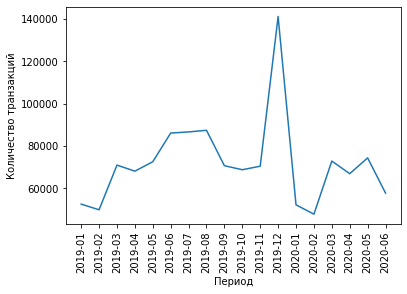

In [14]:
plt.plot(list(transaction_dynamycs.transactions_num))
plt.xlabel("Период")
plt.ylabel("Количество транзакций")
plt.xticks(range(0,len(list(transaction_dynamycs.year_month))),
           list(transaction_dynamycs.year_month), rotation=90)
plt.show()

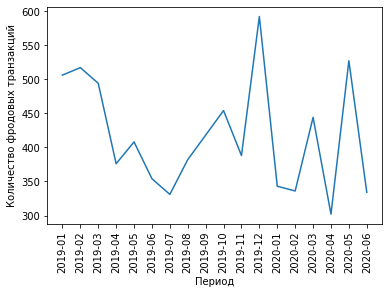

In [15]:
plt.plot(list(transaction_dynamycs.fraud_transactions_num))
plt.xlabel("Период")
plt.ylabel("Количество фродовых транзакций")
plt.xticks(range(0,len(list(transaction_dynamycs.year_month))),
           list(transaction_dynamycs.year_month), rotation=90)
plt.show()

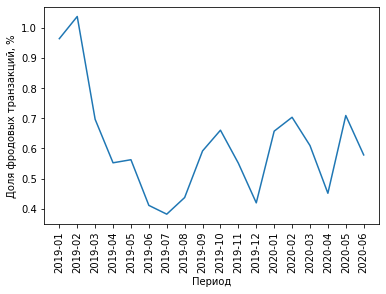

In [16]:
plt.plot(list(transaction_dynamycs.fraud_share))
plt.xlabel("Период")
plt.ylabel("Доля фродовых транзакций, %")
plt.xticks(range(0,len(list(transaction_dynamycs.year_month))),
           list(transaction_dynamycs.year_month), rotation=90)
plt.show()

In [17]:
def get_feature_str(feature_name, target_name, df):
    agg_df = df.groupby([feature_name,target_name], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    pivot_df = agg_df.pivot(index=feature_name, columns=target_name).fillna(0)
    flat_df = pd.DataFrame(pivot_df.to_records())
    flat_df.columns = [feature_name, 'target_0', 'target_1']
    flat_df['target_share'] = flat_df['target_1'] / (flat_df['target_0'] + flat_df['target_1'])
    flat_df.sort_values(by='target_share', ascending=False, inplace = True)
    flat_df.columns = [feature_name, feature_name + '_target_0_cnt', feature_name + '_target_1_cnt', feature_name + '_target_share']
    flat_df = flat_df.drop(feature_name + '_target_0_cnt', axis = 1)
    return flat_df

In [19]:
for i in ['first', 'last', 'cc_num', 'dob', 'zip', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'merchant', 'category']:    
    feature_str = get_feature_str(i, 'is_fraud', train)
    print('Feature name: ' + i)
    print('Feature shape: ' + str(feature_str.shape))
    print('Feature structure')
    print(feature_str.head(25))

Feature name: first
Feature shape: (352, 3)
Feature structure
         first  first_target_1_cnt  first_target_share
235     Meagan                13.0            1.000000
17    Angelica                 7.0            1.000000
25      Arthur                 9.0            1.000000
26      Ashlee                11.0            1.000000
29      Austin                12.0            1.000000
289   Samantha                 7.0            1.000000
333      Traci                11.0            1.000000
269    Phyllis                 8.0            1.000000
54      Calvin                 9.0            1.000000
55     Cameron                 9.0            1.000000
249      Molly                 8.0            1.000000
67     Chelsea                19.0            1.000000
77     Colleen                11.0            1.000000
95      Deanna                10.0            1.000000
100     Dennis                11.0            1.000000
313     Sydney                26.0            0.047970
40 

Feature name: city
Feature shape: (894, 3)
Feature structure
               city  city_target_1_cnt  city_target_share
109        Buellton                8.0                1.0
884       Winnsboro               11.0                1.0
35          Ashland               10.0                1.0
156         Clinton               12.0                1.0
312         Grenola                9.0                1.0
232      East China                9.0                1.0
673      Queen Anne               13.0                1.0
838        Wartburg               11.0                1.0
151        Claypool                7.0                1.0
844          Waukau               10.0                1.0
580      North East                9.0                1.0
449        Lockhart                9.0                1.0
278          Gaines                8.0                1.0
702          Roland               11.0                1.0
543    Mount Vernon               11.0                1.0
378       I

Feature name: job
Feature shape: (494, 3)
Feature structure
                                   job  job_target_1_cnt  job_target_share
332                  Personnel officer              12.0          1.000000
20              Air traffic controller              17.0          1.000000
1                Accountant, chartered              11.0          1.000000
421                        Ship broker               7.0          1.000000
426                          Solicitor              11.0          1.000000
61                     Careers adviser              15.0          1.000000
245                Information officer               8.0          1.000000
35      Armed forces technical officer               8.0          1.000000
243                   Industrial buyer              10.0          1.000000
227                          Homeopath              11.0          1.000000
267                    Legal secretary              12.0          1.000000
201            Forest/woodland manager  

In [1]:
def describe_df(df):
    for i in range(X.shape[1]):
        print('''
              Col. №''' + str(i) + '. Name:' + X.columns[i])
        print(X.dtypes[i])
        if X.dtypes[i] == 'O':
            print(X.iloc[:,i].unique())
        print(X.iloc[:,i].describe)

In [ ]:
describe_df(train)

In [21]:
## plain_map_example
#map_example = Map(location= [train.lat.mean(), train.long.mean()], zoom_start=5.5, tiles="cartodbpositron", 
#                #attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
#            )
#map_example

In [22]:
fraud_only = train.loc[train.is_fraud == 1,:]

In [23]:
def counts_by_hexagon(df, resolution):
    df = df[["merch_lat","merch_long"]].copy(deep=True)
    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["merch_lat"], row["merch_long"], resolution), axis = 1)
    
    df_aggreg = df.groupby(by = "hex_id").size().reset_index()
    df_aggreg.columns = ["hex_id", "value"]

    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: 
                                                           {    "type" : "Polygon",
                                                                 "coordinates": 
                                                                [h3.h3_to_geo_boundary(h=x,geo_json=True)]
                                                            }
                                                        )
    
    return df_aggreg

In [24]:
def hexagons_dataframe_to_geojson(df_hex, file_output = None):
    
    '''Produce the GeoJSON for a dataframe that has a geometry column in geojson format already, along with the columns hex_id and value '''
    
    list_features = []
    
    for i,row in df_hex.iterrows():
        feature = Feature(geometry = row["geometry"] , id=row["hex_id"], properties = {"value" : row["value"]})
        list_features.append(feature)
        
    feat_collection = FeatureCollection(list_features)
    
    geojson_result = json.dumps(feat_collection)
    
    #optionally write to file
    if file_output is not None:
        with open(file_output,"w") as f:
            json.dump(feat_collection,f)
    
    return geojson_result

In [25]:
def choropleth_map(df_aggreg, location, border_color = 'black', fill_opacity = 0.6, initial_map = None, with_legend = False,
                   kind = "linear"):
    #colormap
    min_value = df_aggreg["value"].min()
    max_value = df_aggreg["value"].max()
    m = round ((min_value + max_value ) / 2 , 0)
    
    #take resolution from the first row
    res = h3.h3_get_resolution(df_aggreg.loc[0,'hex_id'])
    
    if initial_map is None:
        initial_map = Map(location=location, zoom_start=11, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
        

    #the colormap 
    #color names accepted https://github.com/python-visualization/branca/blob/master/branca/_cnames.json
    if kind == "linear":
        custom_cm = cm.LinearColormap(['green','yellow','red'], vmin=min_value, vmax=max_value)
    elif kind == "outlier":
        #for outliers, values would be -11,0,1
        custom_cm = cm.LinearColormap(['blue','white','red'], vmin=min_value, vmax=max_value)
    elif kind == "filled_nulls":
        custom_cm = cm.LinearColormap(['sienna','green','yellow','red'], 
                                      index=[0,min_value,m,max_value],vmin=min_value,vmax=max_value)
   

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg)
    
    #plot on map
    name_layer = "Choropleth " + str(res)
    if kind != "linear":
        name_layer = name_layer + kind
        
    GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': custom_cm(feature['properties']['value']),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)

    #add legend (not recommended if multiple layers)
    if with_legend == True:
        custom_cm.add_to(initial_map)
    
    
    
    return initial_map

In [26]:
%%time
df_aggreg = counts_by_hexagon(fraud_only, 3).sort_values(by='value', ascending=False)

Wall time: 336 ms


In [27]:
m_hex = choropleth_map(df_aggreg = df_aggreg, location = [train.lat.mean(), train.long.mean()], with_legend = True)
#m_hex.save('source/3_choropleth_counts_by_hexid9.html')
m_hex

In [33]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [34]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [35]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


In [ ]:
plotScatterMatrix(train, 20, 10)